<a href="https://colab.research.google.com/github/aritroo/Lung-Disease-Detection-SEM-VI-Mini-Project-/blob/master/dl5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) #loading the dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3GN3K1/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3GN3K1/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:

def resize(input_image, input_mask):
  input_image = tf.image.resize(input_image, (128, 128), method="nearest")
  input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
  return input_image, input_mask


In [5]:
def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    # Random flipping of the image and mask
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
 
  return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
 
  return input_image, input_mask


In [8]:

def load_image_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
 
  return input_image, input_mask

In [9]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))
 
  title = ["Input Image", "True Mask", "Predicted Mask"]
 
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
  plt.show()
  

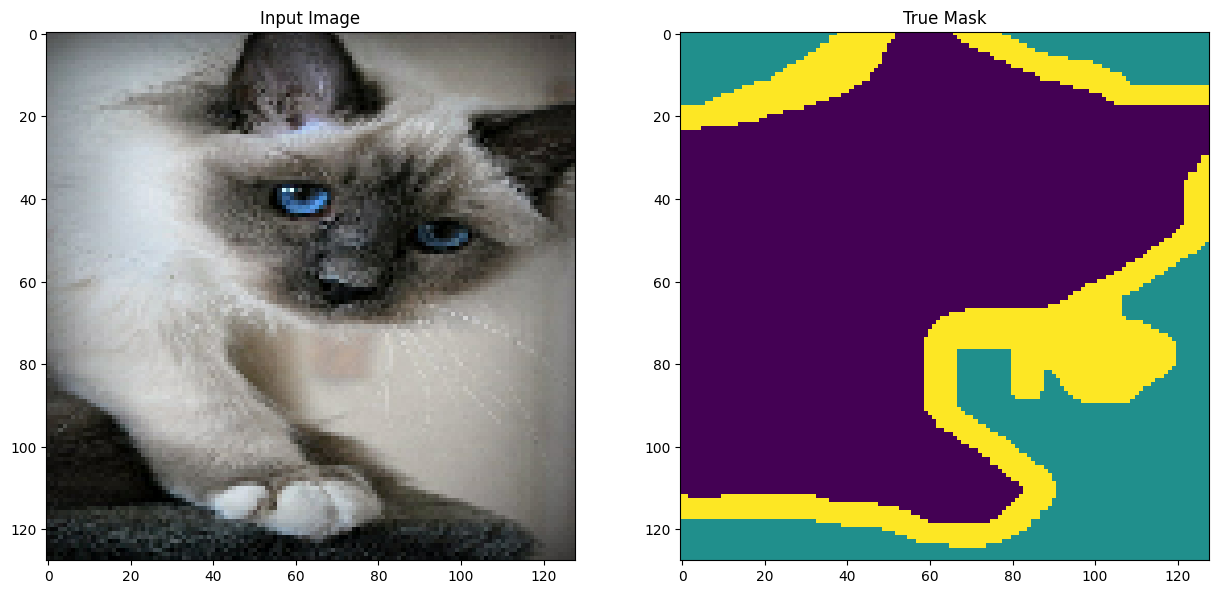

In [13]:
for image, mask in train_dataset.take(33):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [15]:
def double_conv_block(x, n_filters):
  # Conv2D then ReLU activation
  x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Conv2D then ReLU activation
  x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  return x

In [16]:
def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = layers.MaxPool2D(2)(f)
  p = layers.Dropout(0.3)(p)
  return f, p

In [17]:
def upsample_block(x, conv_features, n_filters):
  # upsample
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  # concatenate
  x = layers.concatenate([x, conv_features])
  # dropout
  x = layers.Dropout(0.3)(x)
  # Conv2D twice with ReLU activation
  x = double_conv_block(x, n_filters)
  return x

In [18]:
def build_unet_model():
  inputs = layers.Input(shape=(128,128,3))
  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)
  bottleneck = double_conv_block(p4, 1024)
  u6 = upsample_block(bottleneck, f4, 512)
  u7 = upsample_block(u6, f3, 256)
  u8 = upsample_block(u7, f2, 128)
  u9 = upsample_block(u8, f1, 64)
  outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

In [19]:

unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(unet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics="accuracy")


NUM_EPOCHS = 10
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

In [ ]:
model_history = unet_model.fit(train_batches, epochs=NUM_EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=validation_batches)

Epoch 1/10


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
 
show_predictions()